In [1]:
import os, time, imageio, tqdm, argparse
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np

import torch
print(f"Using PyTorch Version: {torch.__version__}")
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()

import torch.nn.functional as F
from torch.fft import fft2, fftshift
from networks import *
from utils import *
from dataset import *

Using PyTorch Version: 2.5.1+cu124


In [2]:
raw = sio.loadmat('/ad/eng/research/eng_research_cisl/Zhixiong/NeuWS/DATA_DIR/SCENE_NAME/static_objects_static_aberrations/dog_esophagus_0.5diffuser/Zernike_SLM_data/SLM_raw100.mat')
sim = sio.loadmat('/ad/eng/research/eng_research_cisl/Zhixiong/NeuWS/DATA_DIR/SCENE_NAME/static_objects_static_aberrations/dog_esophagus_0.5diffuser/Zernike_SLM_data/SLM_sim100.mat')
raw = raw['imsdata']
sim = sim['proj_sim']

In [3]:
sim.shape

(144, 256)

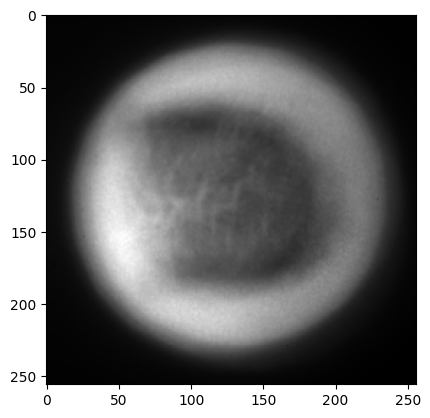

In [4]:
plt.imshow(raw, 'gray')

In [5]:
raw.shape

(256, 256)

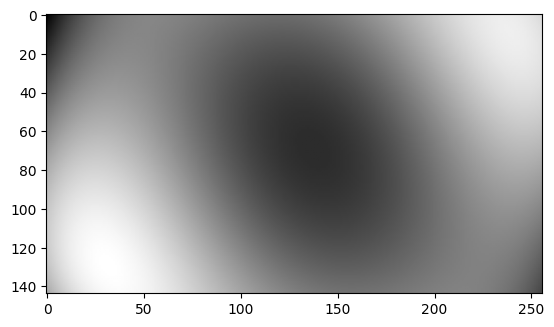

In [6]:
plt.imshow(sim, 'gray')

In [7]:
sim.shape

(144, 256)

In [8]:
wavemo = sio.loadmat('/ad/eng/research/eng_research_cisl/Zhixiong/NeuWS/Wavefront_Modulations.mat')
wavemo = wavemo['slm'][0]

In [9]:
for i in range(4):
    for j in range(4):
        # Save each wavemo as a .mat file
        sio.savemat(f'/ad/eng/research/eng_research_cisl/Zhixiong/NeuWS/wavemo_data/SLM_sim{i*4+j+1}.mat', {'proj_sim': wavemo[i*4+j]})

In [10]:
mod_path = '/ad/eng/research/eng_research_cisl/Zhixiong/NeuWS/Wavefront_Modulations.png'

# Convert image into matrix
mod = imageio.imread(mod_path)
mod = np.array(mod)
# Convert to grayscale
if mod.ndim == 3:
    mod = np.dot(mod[...,:3], [0.2989, 0.5870, 0.1140])
# Normalize to [0, 1]
mod = mod / 255.0
# Convert to uint8
mod = (mod * 255).astype(np.uint8)

/tmp/ipykernel_3276082/574069583.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mod = imageio.imread(mod_path)


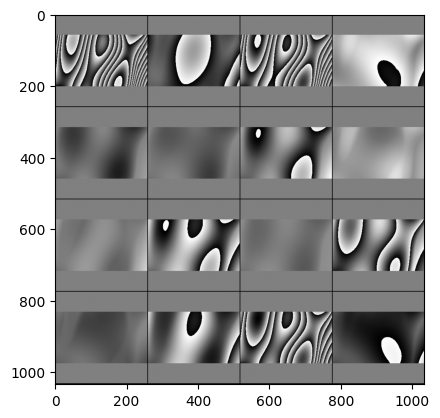

In [11]:
plt.imshow(mod, 'gray')

In [12]:
# Divide the image into 16 equal parts
def divide_image(image, rows, cols):
    # image = image[0:256, 0:256]
    height, width = image.shape
    row_height = height // rows
    col_width = width // cols
    return [image[i*row_height:(i+1)*row_height, j*col_width:(j+1)*col_width] for i in range(rows) for j in range(cols)]
# Divide the image into 4x4 grid
mods = divide_image(mod, 4, 4)


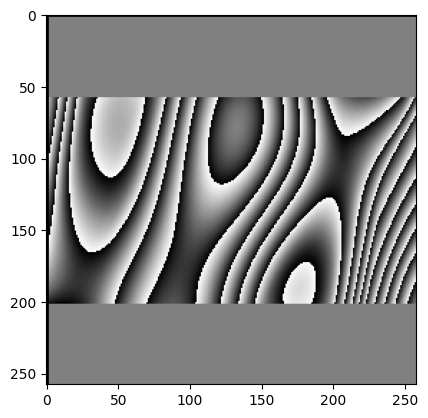

In [13]:
plt.imshow(mods[0], 'gray')

In [14]:
meas_path = '/ad/eng/research/eng_research_cisl/Zhixiong/NeuWS/Modulated_Measurements.png'

# Convert image into matrix
meas = imageio.imread(meas_path)
meas = np.array(meas)
# Convert to grayscale
if meas.ndim == 3:
    meas = np.dot(meas[...,:3], [0.2989, 0.5870, 0.1140])
# Normalize to [0, 1]
meas = meas / 255.0
# Convert to uint8
meas = (meas * 255).astype(np.uint8)

/tmp/ipykernel_3276082/3643146484.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  meas = imageio.imread(meas_path)


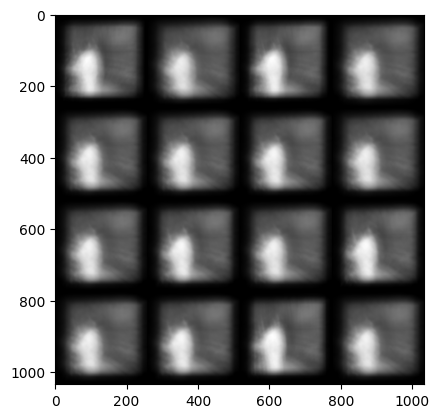

In [15]:
plt.imshow(meas, 'gray')

In [16]:
meas.shape

(1034, 1034)

In [17]:
meass = divide_image(meas, 4, 4)
print(meass[0].shape)

# crop all in meass to 256x256
for i in range(len(meass)):
    meass[i] = meass[i][1:257, 1:257]
print(meass[0].shape)

(258, 258)
(256, 256)


In [18]:
for i in range(4):
    for j in range(4):
        sio.savemat(f'/ad/eng/research/eng_research_cisl/Zhixiong/NeuWS/wavemo_data/SLM_raw{i*4+j+1}.mat', {'imsdata': meass[i*4+j]})

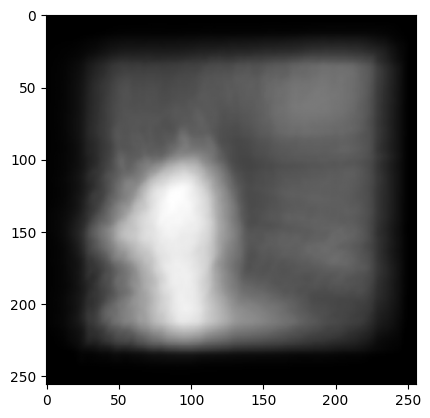

In [19]:
plt.imshow(meass[0], 'gray')

In [20]:
meass[0].shape

(256, 256)

In [21]:
wavemo[0].max()

np.float32(44.054813)

In [22]:
mods[0].max()

np.uint8(254)

In [ ]:
sio.loadmat('/ad/eng/research/eng_research_cisl/Zhixiong/NeuWS/wavemo_data/SLM_sim15.mat').keys()

dict_keys(['__header__', '__version__', '__globals__', 'proj_sim'])

In [ ]:
# Save a tensor as a png file
def save_tensor_as_png(tensor, filename):
    # Convert the tensor to a numpy array
    image = tensor.squeeze().cpu().numpy()
    # Normalize the image to [0, 255]
    image = (image - image.min()) / (image.max() - image.min()) * 255
    # Convert to uint8
    image = image.astype(np.uint8)
    # Save as PNG
    imageio.imwrite(filename, image)